# **Food Delivery Cost and Profitability Analysis using Python**

In [1]:
import pandas as pd

food_orders = pd.read_csv("food_orders_new_delhi.csv")
print(food_orders.head())

   Order ID Customer ID Restaurant ID  Order Date and Time  \
0         1       C8270         R2924  2024-02-01 01:11:52   
1         2       C1860         R2054  2024-02-02 22:11:04   
2         3       C6390         R2870  2024-01-31 05:54:35   
3         4       C6191         R2642  2024-01-16 22:52:49   
4         5       C6734         R2799  2024-01-29 01:19:30   

  Delivery Date and Time  Order Value  Delivery Fee    Payment Method  \
0    2024-02-01 02:39:52         1914             0       Credit Card   
1    2024-02-02 22:46:04          986            40    Digital Wallet   
2    2024-01-31 06:52:35          937            30  Cash on Delivery   
3    2024-01-16 23:38:49         1463            50  Cash on Delivery   
4    2024-01-29 02:48:30         1992            30  Cash on Delivery   

  Discounts and Offers  Commission Fee  Payment Processing Fee  \
0            5% on App             150                      47   
1                  10%             198                  

**The data is now ready with the following adjustments:**

Order Date and Time and Delivery Date and Time columns have been converted to datetime format.

A new column, Discount Amount, has been calculated based on the Discounts and Offers column. This was achieved by extracting percentage discounts or fixed amounts and applying them to the order value.

Discount Percentage has been added to represent the discount rate or fixed amount discount directly.

In [7]:
from datetime import datetime

# convert date and time columns to datetime
food_orders['Order Date and Time'] = pd.to_datetime(food_orders['Order Date and Time'])
food_orders['Delivery Date and Time'] = pd.to_datetime(food_orders['Delivery Date and Time'])

# first, let's create a function to extract numeric values from the 'Discounts and Offers' string
def extract_discount(discount_str):
    # Ensure the input is a string
    if not isinstance(discount_str, str):
        return 0.0

    # Handle fixed amount discounts
    if 'off' in discount_str:
        try:
            discount_value = float(discount_str.split(' ')[0])
            return discount_value
        except (ValueError, IndexError):
            # Return 0 if conversion or splitting fails
            return 0.0

    # Handle percentage-based discounts
    elif '%' in discount_str:
        try:
            percentage_value = float(discount_str.split('%')[0])
            return percentage_value
        except (ValueError, IndexError):
            # Return 0 if conversion or splitting fails
            return 0.0

    # No discount or unrecognized format
    return 0.0

# apply the function to create a new 'Discount Value' column
food_orders['Discount Percentage'] = food_orders['Discounts and Offers'].apply(lambda x: extract_discount(x))

# for percentage discounts, calculate the discount amount based on the order value
food_orders['Discount Amount'] = food_orders.apply(lambda x: (x['Order Value'] * x['Discount Percentage'] / 100)
                                                   if x['Discount Percentage'] > 1
                                                   else x['Discount Percentage'], axis=1)

# adjust 'Discount Amount' for fixed discounts directly specified in the 'Discounts and Offers' column
food_orders['Discount Amount'] = food_orders.apply(lambda x: x['Discount Amount'] if x['Discount Percentage'] <= 1
                                                   else x['Order Value'] * x['Discount Percentage'] / 100, axis=1)

print(food_orders[['Order Value', 'Discounts and Offers', 'Discount Percentage', 'Discount Amount']].head(), food_orders.dtypes)

   Order Value Discounts and Offers  Discount Percentage  Discount Amount
0         1914            5% on App                  5.0            95.70
1          986                  10%                 10.0            98.60
2          937         15% New User                 15.0           140.55
3         1463                  NaN                  0.0             0.00
4         1992         50 off Promo                 50.0           996.00 Order ID                           int64
Customer ID                       object
Restaurant ID                     object
Order Date and Time       datetime64[ns]
Delivery Date and Time    datetime64[ns]
Order Value                        int64
Delivery Fee                       int64
Payment Method                    object
Discounts and Offers              object
Commission Fee                     int64
Payment Processing Fee             int64
Refunds/Chargebacks                int64
Discount Percentage              float64
Discount Amount        

# **Cost and Profitability Analysis**

For the cost analysis, we’ll consider the following costs associated with each order:

Delivery Fee: The fee charged for delivering the order.

Payment Processing Fee: The fee for processing the payment.

Discount Amount: The discount provided on the order.

We’ll calculate the total cost for the platform per order and then aggregate this data to understand the overall cost structure.

The revenue for the platform is mainly derived from the Commission Fee. We’ll calculate the net profit by subtracting the total costs (including discounts) from the revenue generated through commission fees.

In [8]:
# calculate total costs and revenue per order
food_orders['Total Costs'] = food_orders['Delivery Fee'] + food_orders['Payment Processing Fee'] + food_orders['Discount Amount']
food_orders['Revenue'] = food_orders['Commission Fee']
food_orders['Profit'] = food_orders['Revenue'] - food_orders['Total Costs']

# aggregate data to get overall metrics
total_orders = food_orders.shape[0]
total_revenue = food_orders['Revenue'].sum()
total_costs = food_orders['Total Costs'].sum()
total_profit = food_orders['Profit'].sum()

overall_metrics = {
    "Total Orders": total_orders,
    "Total Revenue": total_revenue,
    "Total Costs": total_costs,
    "Total Profit": total_profit
}

print(overall_metrics)

{'Total Orders': 1000, 'Total Revenue': 126990, 'Total Costs': 232709.85, 'Total Profit': -105719.85}


**Based on the analysis, here are the overall metrics for the food delivery operations:**


Total Orders: 1,000

Total Revenue (from Commission Fees): 126,990 INR

Total Costs: 232,709.85 INR (including delivery fees, payment processing fees, and discounts)

Total Profit: -105,719.85 INR


The analysis indicates that the total costs associated with the food delivery operations exceed the total revenue generated from commission fees, resulting in a net loss. It suggests that the current commission rates, delivery fees, and discount strategies might not be sustainable for profitability.

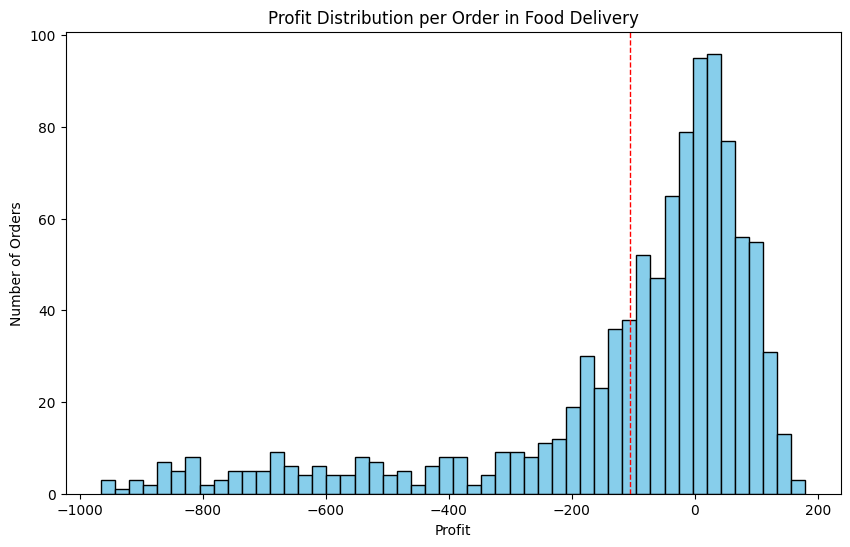

In [9]:
import matplotlib.pyplot as plt

# histogram of profits per order
plt.figure(figsize=(10, 6))
plt.hist(food_orders['Profit'], bins=50, color='skyblue', edgecolor='black')
plt.title('Profit Distribution per Order in Food Delivery')
plt.xlabel('Profit')
plt.ylabel('Number of Orders')
plt.axvline(food_orders['Profit'].mean(), color='red', linestyle='dashed', linewidth=1)
plt.show()

The histogram shows a wide distribution of profit per order, with a noticeable number of orders resulting in a loss (profits below 0).

The red dashed line indicates the average profit, which is in the negative territory, highlighting the overall loss-making situa

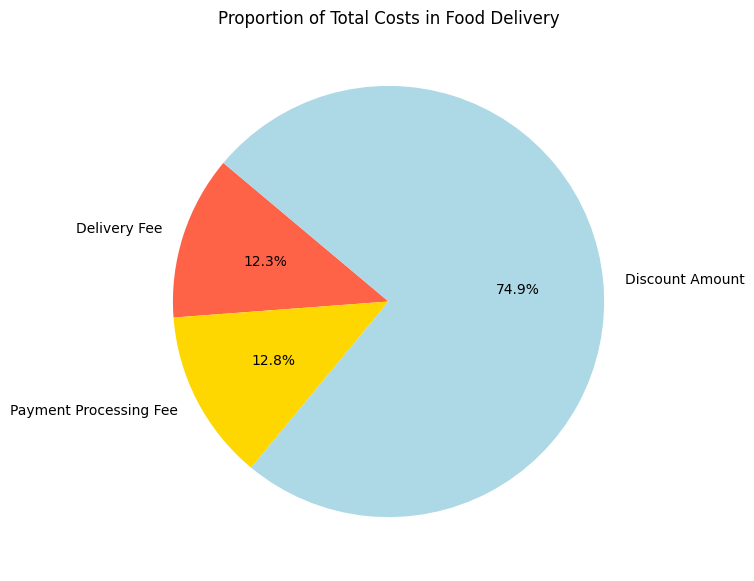

In [10]:
# pie chart for the proportion of total costs
costs_breakdown = food_orders[['Delivery Fee', 'Payment Processing Fee', 'Discount Amount']].sum()
plt.figure(figsize=(7, 7))
plt.pie(costs_breakdown, labels=costs_breakdown.index, autopct='%1.1f%%', startangle=140, colors=['tomato', 'gold', 'lightblue'])
plt.title('Proportion of Total Costs in Food Delivery')
plt.show()

The pie chart illustrates the breakdown of total costs into delivery fees, payment processing fees, and discount amounts.

Discounts constitute a significant portion of the costs, suggesting that promotional strategies might be heavily impacting overall profitability.

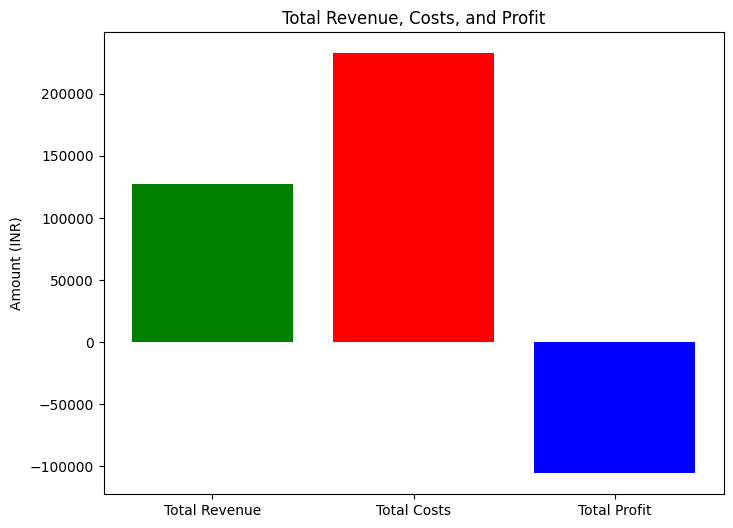

In [11]:
# bar chart for total revenue, costs, and profit
totals = ['Total Revenue', 'Total Costs', 'Total Profit']
values = [total_revenue, total_costs, total_profit]

plt.figure(figsize=(8, 6))
plt.bar(totals, values, color=['green', 'red', 'blue'])
plt.title('Total Revenue, Costs, and Profit')
plt.ylabel('Amount (INR)')
plt.show()

The bar chart compares total revenue, total costs, and total profit.

It visually represents the gap between revenue and costs, clearly showing that the costs surpass the revenue, leading to a total loss.

# **A New Strategy for Profits**
From the analysis so far we understood that the discounts on food orders are resulting in huge losses. Now, we need to find a new strategy for profitability. We need to find a sweet spot for offering discounts and charging commissions. To find a sweet spot for commission and discount percentages, we can analyze the characteristics of profitable orders more deeply.

Specifically, we need to look for:



*   A new average commission percentage based on profitable orders.
*   A new average discount percentage for profitable orders, that could serve as a guideline for what level of discount still allows for profitability.

Given these new averages, we can suggest adjustments that might not only make individual orders profitable but also apply broadly across all orders to improve overall profitability.

Let’s calculate:

The average commission percentage for profitable orders.
The average discount percentage for profitable orders.

In [17]:
# Filter the dataset for profitable orders
profitable_orders = food_orders[food_orders['Profit'] > 0].copy()

# Calculate the average commission percentage for profitable orders
profitable_orders.loc[:, 'Commission Percentage'] = (profitable_orders['Commission Fee'] / profitable_orders['Order Value']) * 100

# Calculate the average discount percentage for profitable orders
profitable_orders.loc[:, 'Effective Discount Percentage'] = (profitable_orders['Discount Amount'] / profitable_orders['Order Value']) * 100

# Calculate the new averages
new_avg_commission_percentage = profitable_orders['Commission Percentage'].mean()
new_avg_discount_percentage = profitable_orders['Effective Discount Percentage'].mean()

# Print the results
print("Average Commission: ", new_avg_commission_percentage)
print("Average Discount Percentage: ", new_avg_discount_percentage)


Average Commission:  30.508436145149435
Average Discount Percentage:  5.867469879518072


Based on the analysis of profitable orders, we find a new set of averages that could represent a “sweet spot” for commission and discount percentages:


*   New Average Commission Percentage: 30.51%
*   New Average Discount Percentage: 5.87%



The average commission percentage for profitable orders is significantly higher than the overall average across all orders. It suggests that a higher commission rate on orders might be a key factor in achieving profitability. The average discount percentage for profitable orders is notably lower than the overall average, indicating that lower discounts might contribute to profitability without significantly deterring order volume.

Based on this analysis, a strategy that aims for a commission rate closer to 30% and a discount rate around 6% could potentially improve profitability across the board.